# A Review of Histogram Equalization Techniques in Image Enhancement Application 

## 1 Fundamental Histogram Equalization Algorithm

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

(512, 512)
2846


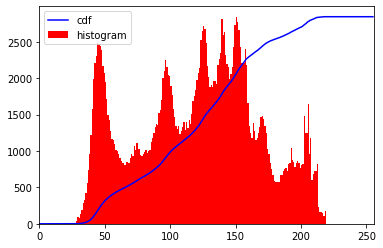

In [3]:
img = cv2.imread('./images/lenna.bmp', 0) # Using 0 to read image in grayscale mode 
print(img.shape)
hist, bins = np.histogram(img.flatten(), 256, [0, 256])

cdf = hist.cumsum()
cdf_normalized = cdf * hist.max() / cdf.max()
print(hist.max())

plt.plot(cdf_normalized, color='b')
plt.hist(img.flatten(), 256, [0,256], color='r')
plt.xlim([0,256])
plt.legend(('cdf', 'histogram'), loc='upper left')
plt.show()

Text(0.5, 1.0, "'Original' 'EH'")

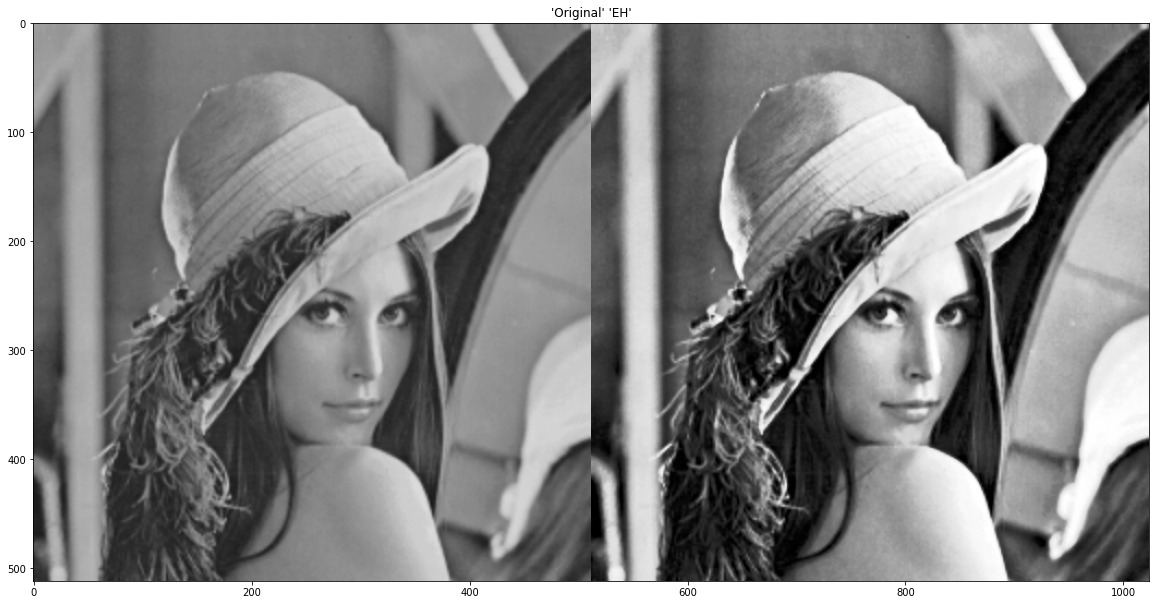

In [4]:
cdf_m = np.ma.masked_equal(cdf, 0)
cdf_m = (cdf_m - cdf_m.min())*255 / (cdf_m.max() - cdf_m.min())
cdf = np.ma.filled(cdf_m, 0).astype('uint8')

img2 = cdf[img]
res = np.hstack((img, img2))
plt.figure(figsize=(20,20))
plt.imshow(res, cmap="gray")
plt.title("'Original' 'EH'")

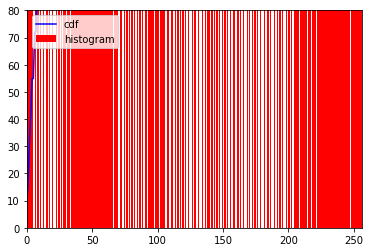

In [5]:
hist, bins = np.histogram(img2.flatten(), 256, [0, 256])

cdf = hist.cumsum()
cdf_normalized = cdf * hist.max() / cdf.max()

plt.plot(cdf_normalized, color='b')
plt.hist(img2.flatten(), 256, [0, 256], color='r')
plt.xlim([0, 256])
plt.ylim([0, 80])
plt.legend(('cdf', 'histogram'), loc='upper left')
plt.show()

**Implemented with OpenCV**

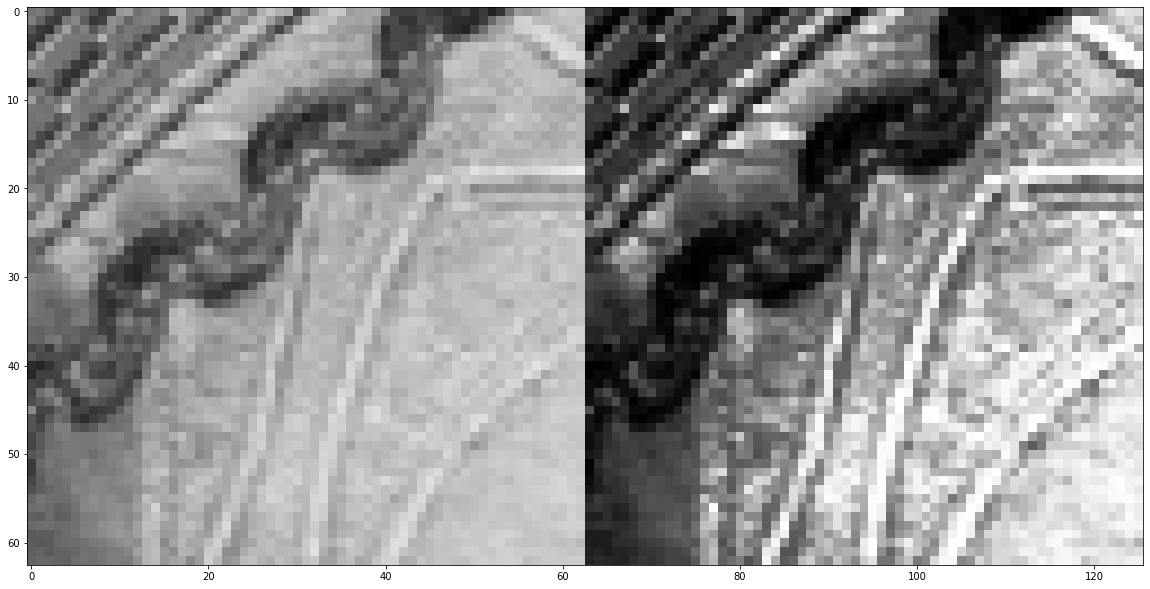

In [6]:
img = cv2.imread('./images/0005_gt.png', 0)
equ = cv2.equalizeHist(img)
res = np.hstack((img,equ))
cv2.imwrite('./images/res.png', res)

plt.figure(figsize=(20,20))
plt.imshow(res, cmap='gray')

**Implemented with Skimage**

c:\users\dell\appdata\local\programs\python\python38\lib\site-packages\skimage\exposure\exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)


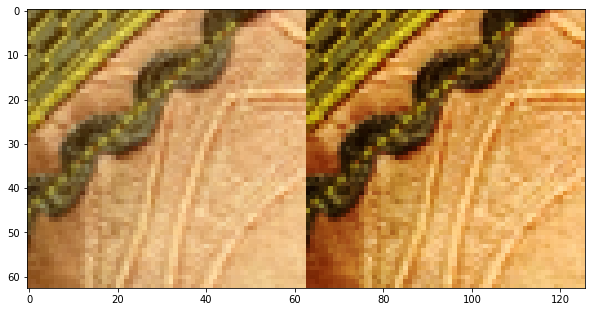

In [7]:
from skimage import data, img_as_float
from skimage import exposure

img = plt.imread('./images/0005_gt.png')
img = img_as_float(img)
img_eq = exposure.exposure.equalize_hist(img)
res = np.hstack((img, img_eq))
cv2.imwrite('./images/res.png', res)

plt.figure(figsize=(10,10))
plt.imshow(res, cmap='gray')

## 2 Bi-Histogram Equalization (BBHE)

More fundamental reason behind such limitations of the histogram equalization is that the histogram equalization **does not take the mean brightness** of an image into account.

In [8]:
def BHE(img):
    
    img_mean = int(np.mean(img))
    
    img_l = img.flatten().compress((img.flatten() <= img_mean).flat)
    img_u = img.flatten().compress((img.flatten() >  img_mean).flat)
    
    hist_l, bins_l = np.histogram(img_l, img_mean+1, [0, img_mean])
    pdf_l = hist_l / np.prod(img_l.size)
    cdf_l = pdf_l.cumsum()
    
    cdf_l = cdf_l * (img_mean - img.min()) + img.min()
    
    hist_u, bins_u = np.histogram(img_u, 256-img_mean, [img_mean+1, 256])
    pdf_u = hist_u / np.prod(img_u.size)
    cdf_u = pdf_u.cumsum()
    
    cdf_u = cdf_u * (img.max() - (int(img_mean) + 1)) + (int(img_mean) + 1)
    
    cdf_new = np.concatenate((cdf_l, cdf_u))
    new_img = cdf_new[img.ravel()]
    img_eq = np.reshape(new_img, img.shape)
    
    return img_eq

Text(0.5, 1.0, "'Original'          'Fundamental Histogram Equalization'           'BBHE'")

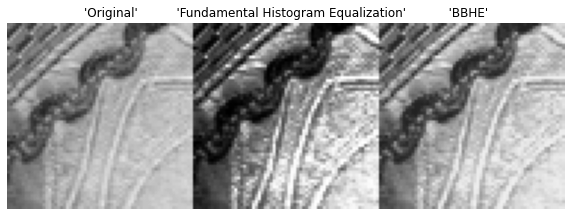

In [9]:
img = cv2.imread('./images/0005_gt.png', 0)
img_BBHE = BHE(img)
res = np.hstack((img, equ, img_BBHE))

plt.figure(figsize=(10,10))
plt.imshow(res, cmap='gray')
plt.axis('off')
plt.title("'Original'          'Fundamental Histogram Equalization'           'BBHE'")

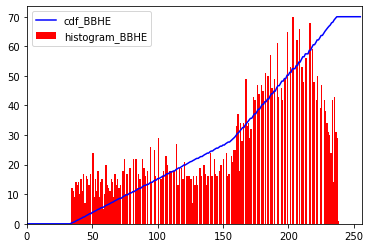

In [10]:
hist_BBHE, bins_BBHE = np.histogram(img_BBHE.flatten(), 256, [0, 256])

cdf_BBHE = hist_BBHE.cumsum()
cdf_normalized_BBHE = cdf_BBHE * hist_BBHE.max() / cdf_BBHE.max()

plt.plot(cdf_normalized_BBHE, color='b')
plt.hist(img_BBHE.flatten(), 256, [0,256], color='r')
plt.xlim([0,256])
plt.legend(('cdf_BBHE', 'histogram_BBHE'), loc='upper left')
plt.show()

**It can be found that BHE basically maintains the brightness level of the original picture, making the result of the equalization more natural, and some details in the picture will be seen more clearly than the original picture.**

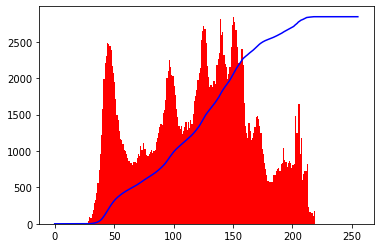

In [11]:
# np.set_printoptions(threshold=np.inf)
img = cv2.imread('./images/lenna.bmp', 0)

img_vec = []
for i in img:
    for j in i:
        img_vec.append(j)
        
h, b, _ = plt.hist(img_vec, 256, [0, 256], color='r')

h_cdf = h.cumsum()
h_cdf_nor = h_cdf * h.max() / h_cdf.max()
plt.plot(h_cdf_nor, color='b')

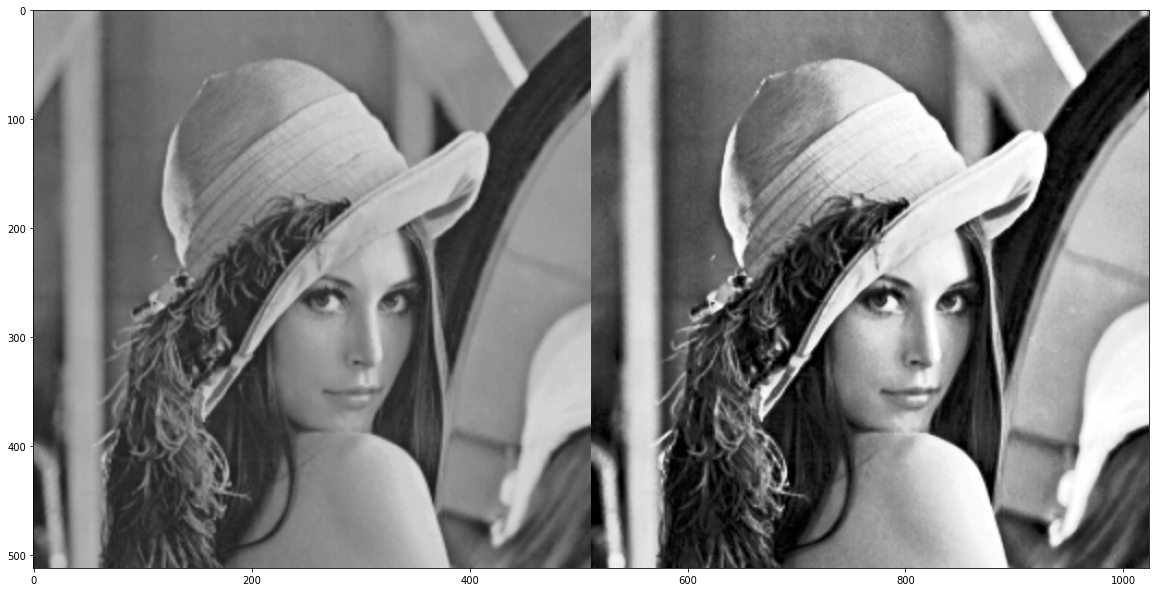

In [12]:
h_cdf_m = (h_cdf - h_cdf.min())*255 / (h_cdf.max() - h_cdf.min())

img_self = h_cdf_m[img]
res = np.hstack((img, img_self))
plt.figure(figsize=(20,20))
plt.imshow(res, cmap='gray')

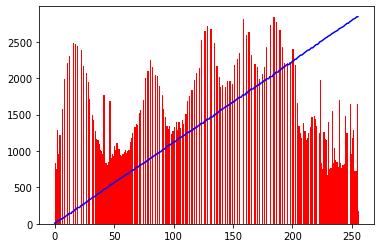

In [106]:
img_vec = []
for i in img_self:
    for j in i:
        img_vec.append(j)
        
h, b, _ = plt.hist(img_vec, 256, [0, 256], color='r')

h_cdf = h.cumsum()
h_cdf_nor = h_cdf * h.max() / h_cdf.max()
plt.plot(h_cdf_nor, color='b')

## 3 Clipped Histogram Equalization

In [13]:
def clip_histogram(hist, clip_limit):
    """Perform clipping of the histogram and redistribution of bins.
    The histogram is clipped and the number of excess pixels is counted.
    Afterwards the excess pixels are equally redistributed across the
    whole histogram (providing the bin count is smaller than the cliplimit).
    Parameters
    ----------
    hist : ndarray
        Histogram array.
    clip_limit : int
        Maximum allowed bin count.
    Returns
    -------
    hist : ndarray
        Clipped histogram.
    """
    # calculate total number of excess pixels
    excess_mask = hist > clip_limit
    excess = hist[excess_mask]
    n_excess = excess.sum() - excess.size * clip_limit
    hist[excess_mask] = clip_limit

    # Second part: clip histogram and redistribute excess pixels in each bin
    bin_incr = n_excess // hist.size  # average binincrement
    upper = clip_limit - bin_incr  # Bins larger than upper set to cliplimit

    low_mask = hist < upper
    n_excess -= hist[low_mask].size * bin_incr
    hist[low_mask] += bin_incr

    mid_mask = np.logical_and(hist >= upper, hist < clip_limit)
    mid = hist[mid_mask]
    n_excess += mid.sum() - mid.size * clip_limit
    hist[mid_mask] = clip_limit

    while n_excess > 0:  # Redistribute remaining excess
        prev_n_excess = n_excess
        for index in range(hist.size):
            under_mask = hist < clip_limit
            step_size = max(1, np.count_nonzero(under_mask) // n_excess)
            under_mask = under_mask[index::step_size]
            hist[index::step_size][under_mask] += 1
            n_excess -= np.count_nonzero(under_mask)
            if n_excess <= 0:
                break
        if prev_n_excess == n_excess:
            break

    return hist

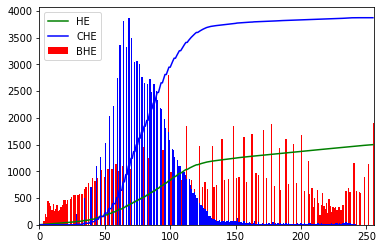

In [22]:
img = cv2.imread('./images/endo.png', 0) # Using 0 to read image in grayscale mode 
hist, bins = np.histogram(img.flatten(), 256, [0, 256])

cdf = hist.cumsum()
cdf_normalized = cdf * hist.max() / cdf.max()

hists = clip_histogram(hist, 1500)
hists_CHE = np.array(hists)

cdf_CHE = hists_CHE.cumsum()
cdf_normalized_CHE = cdf_CHE * hists_CHE.max() / cdf_CHE.max()

plt.plot(cdf_normalized_CHE, color='g')
plt.plot(cdf_normalized, color='b')
plt.hist(img2.flatten(), 256, [0,256], color='r')
plt.hist(img.flatten(), 256, [0,256], color='b')
plt.xlim([0,256])
plt.legend(('HE', 'CHE', 'BHE'), loc='upper left')
plt.show()

Text(0.5, 1.0, "'Original'                   'HE'                         'CHE'")

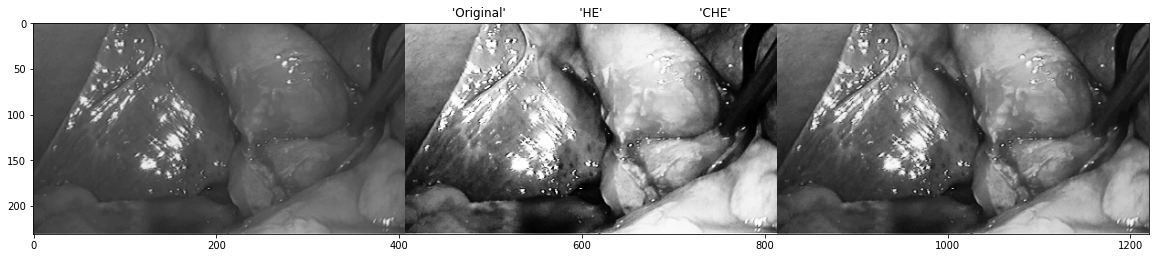

In [23]:
cdf_m = np.ma.masked_equal(cdf, 0)
cdf_m = (cdf_m - cdf_m.min())*255 / (cdf_m.max() - cdf_m.min())
cdf = np.ma.filled(cdf_m, 0).astype('uint8')

cdf_m_CHE = np.ma.masked_equal(cdf_CHE, 0)
cdf_m_CHE = (cdf_m_CHE - cdf_m_CHE.min())*255 / (cdf_m_CHE.max() - cdf_m_CHE.min())
cdf_CHE = np.ma.filled(cdf_m_CHE, 0).astype('uint8')

img1 = cdf[img]
img2 = cdf_CHE[img]
res = np.hstack((img, img1, img2))
plt.figure(figsize=(20,20))
plt.imshow(res, cmap="gray")
plt.title("'Original'                   'HE'                         'CHE'")

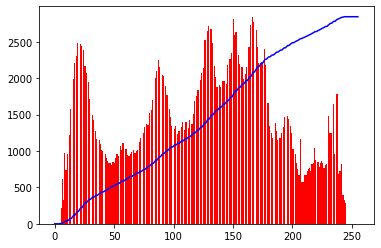

In [126]:
img_vec = []
for i in img2:
    for j in i:
        img_vec.append(j)
        
h, b, _ = plt.hist(img_vec, 256, [0, 256], color='r')

h_cdf = h.cumsum()
h_cdf_nor = h_cdf * h.max() / h_cdf.max()
plt.plot(h_cdf_nor, color='b')

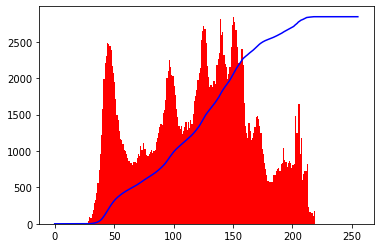

In [128]:
img_vec = []
for i in img:
    for j in i:
        img_vec.append(j)
        
h, b, _ = plt.hist(img_vec, 256, [0, 256], color='r')

h_cdf = h.cumsum()
h_cdf_nor = h_cdf * h.max() / h_cdf.max()
plt.plot(h_cdf_nor, color='b')